# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 9.2MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as KK

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Fri Feb  5 02:32:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/data'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc', 'quora', 'songys']

In [7]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5']

# Attention

In [8]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [9]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [10]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
    question_list.append([word_to_id[word] for word in pair[0].split()])
    answer_list.append([word_to_id[word] for word in pair[1].split()])

# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []

for question, answer in zip(question_list, answer_list):
    train_enc_inputs.append(question)
    train_dec_inputs.append([word_to_id['[BOS]']] + answer)
    train_labels.append(answer + [word_to_id['[EOS]']])

# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 5)
for row in train_dec_inputs:
    row += [0] * (5 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 5)
for row in train_labels:
    row += [0] * (5 - len(row))

# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  9, 10,  7],
        [ 2, 10, 12,  0,  0]]), array([[ 8,  9, 10,  7,  3],
        [10, 12,  3,  0,  0]]))

In [11]:
# random embed weight
embed_weight = np.random.randint(-9, 9, (len(id_to_word), 5)) / 10

# embedding 생성
embedding = tf.keras.layers.Embedding(len(id_to_word), 5, weights=[embed_weight])

# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc, hidden_dec

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [ 0.2,  0.8,  0.5, -0.2,  0.1],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [-0.4,  0.4, -0.3, -0.2, -0.5],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
 array([[[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3, -0.4,  0.8, -0.4,  0.4],
         [ 0.7,  0. , -0.1,  0.3, -0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [-0.6, -0.4,  0.5,  0.6,  0.6],
         [ 0.6, -0.3,  0.3,  0.6,  0.8],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>)

In [12]:
# Q, K, V 선언
Q = hidden_dec
K = hidden_enc
V = K

In [13]:
# (bs, n_seq, d_model)
# Q[0][0] & K[0][0]
q_idx, k_idx = 0, 0
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b=True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2 -0.9  0.   0.2  0.7], shape=(5,), dtype=float32)
0.49
tf.Tensor([[0.49]], shape=(1, 1), dtype=float32)
0.49


In [14]:
# Q[0][0] & K[0][1]
q_idx, k_idx = 0, 1
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b=True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([-0.6 -0.7  0.3 -0.8  0.2], shape=(5,), dtype=float32)
-0.74
tf.Tensor([[-0.74]], shape=(1, 1), dtype=float32)
-0.74


In [15]:
# Q[0][0] & K[0][2]
q_idx, k_idx = 0, 2
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b=True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2  0.8  0.5 -0.2  0.1], shape=(5,), dtype=float32)
0.33
tf.Tensor([[0.33]], shape=(1, 1), dtype=float32)
0.33


In [16]:
# Q[0][0] & K[0][3]
q_idx, k_idx = 0, 3
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b=True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2  0.5  0.8  0.4 -0.9], shape=(5,), dtype=float32)
0.63
tf.Tensor([[0.63]], shape=(1, 1), dtype=float32)
0.63


In [17]:
# Q[0][0] & K[0][*]
attn_row = []
q_val = Q[0][0]
for k_idx in range(4):
    k_val = K[0][k_idx]
    attn_row.append(tf.matmul([q_val], [k_val], transpose_b=True).numpy()[0][0])
attn_row

[0.49, -0.74, 0.33, 0.63]

In [18]:
# Q[0][*] & K[0][*]
for q_idx in range(5):
    attn_row = []
    q_val = Q[1][q_idx]
    for k_idx in range(4):
        k_val = K[1][k_idx]
        attn_row.append(tf.matmul([q_val], [k_val], transpose_b=True).numpy()[0][0])
    print(attn_row)

[0.49, -0.74, -0.75, 1.26]
[-0.87, -0.9, 0.13, -0.01999998]
[0.78, 0.42999995, -0.49, 0.75]
[1.0699999, -0.38, -0.97, 1.5400001]
[1.0699999, -0.38, -0.97, 1.5400001]


In [19]:
# attention score
attn_score = tf.matmul(Q, K, transpose_b=True).numpy()
attn_score

array([[[ 0.49      , -0.74      ,  0.33      ,  0.63      ],
        [ 0.62      ,  0.74      ,  0.26      , -0.01999995],
        [-0.01000001, -0.75000006,  0.        ,  0.45000002],
        [-0.87      , -0.9       ,  0.77000004,  1.83      ],
        [-0.96      , -0.73      ,  0.6700001 ,  1.9       ]],

       [[ 0.49      , -0.74      , -0.75      ,  1.26      ],
        [-0.87      , -0.9       ,  0.13      , -0.01999998],
        [ 0.78      ,  0.42999995, -0.49      ,  0.75      ],
        [ 1.0699999 , -0.38      , -0.97      ,  1.5400001 ],
        [ 1.0699999 , -0.38      , -0.97      ,  1.5400001 ]]],
      dtype=float32)

In [22]:
# attention prob
attn_prob = tf.nn.softmax(attn_score, axis=-1).numpy()
attn_prob

array([[[0.30351683, 0.08871571, 0.25863996, 0.34912744],
        [0.2982879 , 0.3363187 , 0.20810843, 0.15728496],
        [0.24562553, 0.11719136, 0.24809413, 0.38908905],
        [0.0454435 , 0.04410044, 0.23426896, 0.6761871 ],
        [0.0402836 , 0.05070093, 0.20560242, 0.70341307]],

       [[0.26727656, 0.07812295, 0.07734562, 0.5772549 ],
        [0.14228041, 0.13807541, 0.38675827, 0.3328859 ],
        [0.33829898, 0.23839524, 0.09500505, 0.32830074],
        [0.33731437, 0.07912394, 0.04386055, 0.53970116],
        [0.33731437, 0.07912394, 0.04386055, 0.53970116]]], dtype=float32)

In [23]:
# prob sum 확인
np.sum(attn_prob, axis=-1)

array([[0.9999999, 1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       , 1.       ]],
      dtype=float32)

In [24]:
# attn_prob[0][0][0] & V[0][0]
p_idx, v_idx = 0, 0
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_0_0_0 = p_val * v_val
attn_out_0_0_0

0.30351683
tf.Tensor([ 0.2 -0.9  0.   0.2  0.7], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06070337, -0.27316514,  0.        ,  0.06070337,  0.21246178],
      dtype=float32)>

In [25]:
# attn_prob[0][0][1] & V[0][1]
p_idx, v_idx = 1, 1
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_0_0_1 = p_val * v_val
attn_out_0_0_1

0.08871571
tf.Tensor([-0.6 -0.7  0.3 -0.8  0.2], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.05322943, -0.062101  ,  0.02661471, -0.07097257,  0.01774314],
      dtype=float32)>

In [26]:
# attn_prob[0][0][2] & V[0][2]
p_idx, v_idx = 2, 2
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_0_0_2 = p_val * v_val
attn_out_0_0_2

0.25863996
tf.Tensor([ 0.2  0.8  0.5 -0.2  0.1], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.05172799,  0.20691197,  0.12931998, -0.05172799,  0.025864  ],
      dtype=float32)>

In [29]:
# attn_prob[0][0][3] & V[0][3]
p_idx, v_idx = 3, 3
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_0_0_3 = p_val * v_val
attn_out_0_0_3

0.34912744
tf.Tensor([ 0.2  0.5  0.8  0.4 -0.9], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06982549,  0.17456372,  0.27930197,  0.13965099, -0.31421468],
      dtype=float32)>

In [30]:
# attn_prob[0][0][*] & V[0][*]
attn_out_0_0 = attn_out_0_0_0 + attn_out_0_0_1 + attn_out_0_0_2 + attn_out_0_0_3
print(attn_out_0_0)

tf.Tensor([ 0.12902743  0.04620954  0.43523666  0.0776538  -0.05814576], shape=(5,), dtype=float32)


In [31]:
# attn_prob[0][0][*] & V[0][*]
attn_row = []
for v_idx in range(4):
    attn_row.append(attn_prov[0][0][v_idx] * V[0][v_idx])
print(attn_row)
print(np.sum(attn_row, axis=0))

[<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06070337, -0.27316514,  0.        ,  0.06070337,  0.21246178],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.05322943, -0.062101  ,  0.02661471, -0.07097257,  0.01774314],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.05172799,  0.20691197,  0.12931998, -0.05172799,  0.025864  ],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06982549,  0.17456372,  0.27930197,  0.13965099, -0.31421468],
      dtype=float32)>]
[ 0.12902743  0.04620954  0.43523666  0.0776538  -0.05814576]


In [32]:
# attn_prov[0][*] & V[0][*]
for q_idx in range(5):
    attn_row = []
    for v_idx in range(4):
        attn_row.append(attn_prov[0][q_idx][v_idx] * V[0][v_idx])
    print(np.sum(attn_row, axis=0))

[ 0.12902743  0.04620954  0.43523666  0.0776538  -0.05814576]
[-0.06905498 -0.25875294  0.3307778  -0.1881051   0.15531965]
[ 0.10624693  0.0899229   0.47047573  0.06138881 -0.12999457]
[ 0.16471966  0.45373926  0.6713143   0.1974294  -0.54451096]
[ 0.15943927  0.44444257  0.68074197  0.20774074 -0.5741728 ]


In [33]:
# attn_prob & V
attn_out = tf.matmul(attn_prov, V)
attn_out

<tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
array([[[ 0.12902743,  0.04620954,  0.43523666,  0.07765379,
         -0.05814578],
        [-0.06905498, -0.25875294,  0.3307778 , -0.18810509,
          0.15531965],
        [ 0.10624693,  0.0899229 ,  0.47047573,  0.06138882,
         -0.12999459],
        [ 0.16471964,  0.45373926,  0.6713143 ,  0.1974294 ,
         -0.54451096],
        [ 0.15943927,  0.44444263,  0.68074197,  0.20774072,
         -0.5741728 ]],

       [[ 0.32199624, -0.43747318,  0.17340967,  0.3218408 ,
          0.6258493 ],
        [-0.00936093, -0.16986763,  0.02526091,  0.04037564,
          0.20014095],
        [ 0.08360107, -0.53183395,  0.1415073 ,  0.05492304,
          0.4996264 ],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547]]], dtype=float32)>

In [36]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        Q, K, V = inputs
        #####################################
        # attention score (dot-product)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # attention prov
        attn_prob = tf.nn.softmax(attn_score)
        # weighted sum
        attn_out = tf.matmul(attn_prob, V)
        #####################################
        return attn_out

In [37]:
attention = DotProductAttention()
attention((Q, K, V))

<tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
array([[[ 0.12902743,  0.04620954,  0.43523666,  0.07765379,
         -0.05814578],
        [-0.06905498, -0.25875294,  0.3307778 , -0.18810509,
          0.15531965],
        [ 0.10624693,  0.0899229 ,  0.47047573,  0.06138882,
         -0.12999459],
        [ 0.16471964,  0.45373926,  0.6713143 ,  0.1974294 ,
         -0.54451096],
        [ 0.15943927,  0.44444263,  0.68074197,  0.20774072,
         -0.5741728 ]],

       [[ 0.32199624, -0.43747318,  0.17340967,  0.3218408 ,
          0.6258493 ],
        [-0.00936093, -0.16986763,  0.02526091,  0.04037564,
          0.20014095],
        [ 0.08360107, -0.53183395,  0.1415073 ,  0.05492304,
          0.4996264 ],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547]]], dtype=float32)>

# 모델링

In [40]:
# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc, hidden_dec

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [ 0.2,  0.8,  0.5, -0.2,  0.1],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [-0.4,  0.4, -0.3, -0.2, -0.5],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
 array([[[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3, -0.4,  0.8, -0.4,  0.4],
         [ 0.7,  0. , -0.1,  0.3, -0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [-0.6, -0.4,  0.5,  0.6,  0.6],
         [ 0.6, -0.3,  0.3,  0.6,  0.8],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>)

In [42]:
# encoder lstm
fw_cell = tf.keras.layers.LSTM(units=4, return_state=True, return_sequences=True)
bw_cell = tf.keras.layers.LSTM(units=4, go_backwards=True, return_state=True, return_sequences=True)
lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)

hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)
hidden_enc.shape, fw_h.shape, fw_c.shape, bw_h.shape, bw_c.shape

(TensorShape([2, 4, 8]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]))

In [43]:
# concat hidden & cell
s_h = tf.concat([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
s_c = tf.concat([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)
s_h.shape, s_c.shape

(TensorShape([2, 8]), TensorShape([2, 8]))

In [44]:
# decoder LSTM
lstm_dec = tf.keras.layers.LSTM(units=8, return_sequences=True)
hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
hidden_dec.shape

TensorShape([2, 5, 8])

In [45]:
# attention
attention = DotProductAttention()
attn_out = attention((hidden_dec, hidden_enc, hidden_enc))
attn_out.shape

TensorShape([2, 5, 8])

In [46]:
# concat output
dec_out = tf.concat([attn_out, hidden_dec], axis=-1)
dec_out.shape

TensorShape([2, 5, 16])

In [47]:
# 다음단어 예측
dense_out = tf.keras.layers.Dense(units=len(word_to_id), activation=tf.nn.softmax)
outputs = dense_out(dec_out)  # (bs, n_dec_seq, n_vocab)
outputs.shape

TensorShape([2, 5, 13])

In [56]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    seq2seq 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    ################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)

    # Encoder LSTM (uni-direction, bi-direction 가능)
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_state=True, return_sequences=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_state=True, return_sequences=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, n_enc_seq, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)

    # Concatenate hidden states and cell states
    s_h = tf.concat([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = tf.concat([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)

    # Decoder LSTM (uni-direction만 가능)
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)

    # attention
    attention = DotProductAttention()
    attn_out = attention((hidden_dec, hidden_enc, hidden_enc))

    # concat output
    dec_out = tf.concat([attn_out, hidden_dec], axis=-1)
    
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(dec_out)  # (bs, n_dec_seq, n_vocab)
    ################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

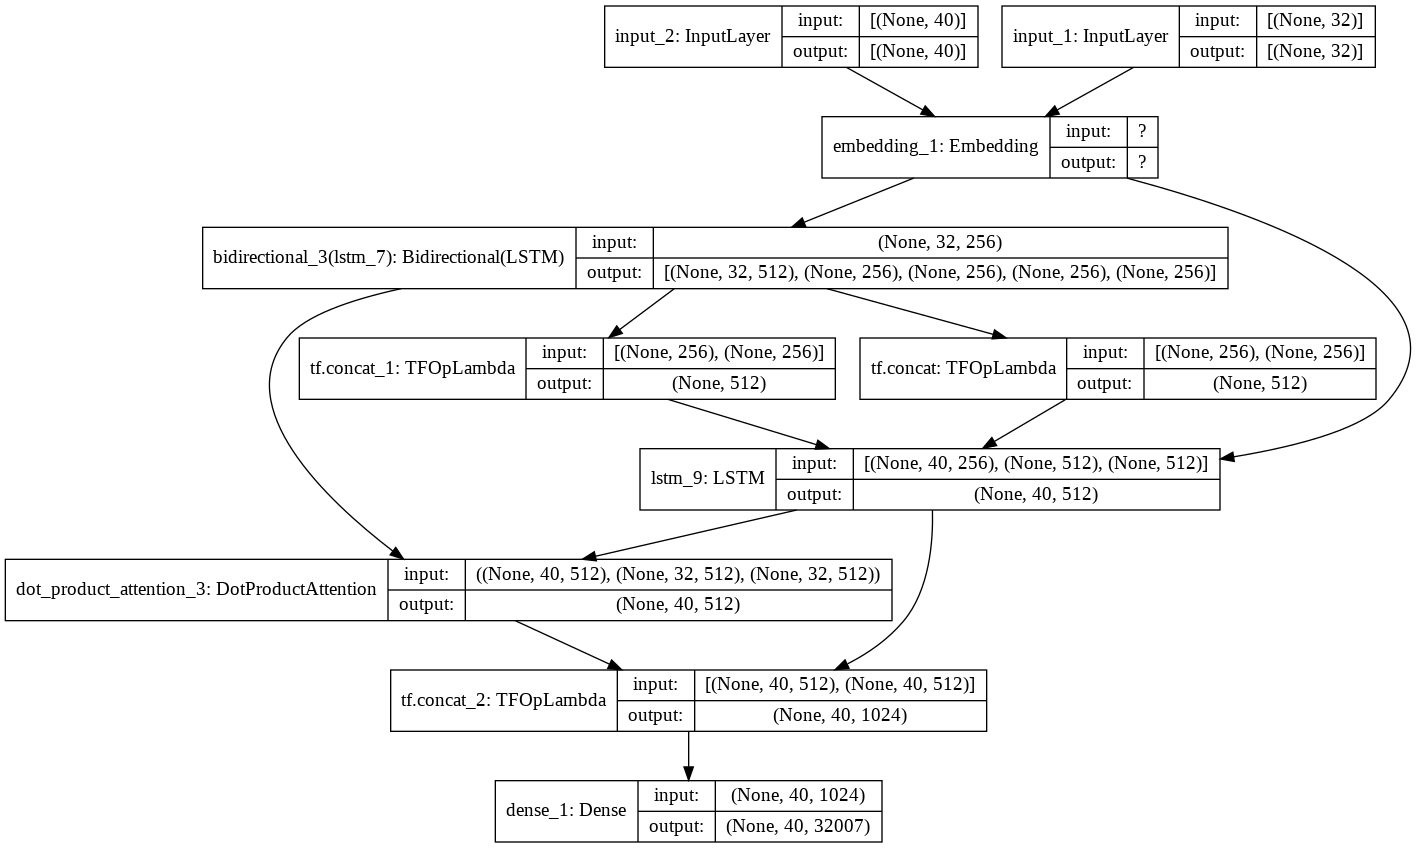

In [57]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Vocabulary & config

In [54]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [55]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# Loss & Acc

In [58]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [59]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Sample Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

In [ ]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        Q = row['Q']
        A = row['A']
        print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]
        print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [ ]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm_dot.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm_dot.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=400,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm_dot.hdf5'))

In [ ]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

# All Data Project

## Data


In [60]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
print(len(df_train))
df_train = df_train.dropna()
print(len(df_train))
df_train

11823
11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [61]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        Q = row['Q']
        A = row['A']

        tokens_q = vocab.encode_as_pieces(Q)
        tokens_a = vocab.encode_as_pieces(A)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [62]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

(array([[   89,    56,    10, ...,     0,     0,     0],
        [   35,    47,  1004, ...,     0,     0,     0],
        [   38,   819,   362, ...,     0,     0,     0],
        ...,
        [ 2886,  9525, 21930, ...,     0,     0,     0],
        [10736,  8256,  1172, ...,     0,     0,     0],
        [26128,    70,  1381, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2261,    19, ...,     0,     0,     0],
        [    2,  4594,    61, ...,     0,     0,     0],
        [    2,  2350,    18, ...,     0,     0,     0],
        ...,
        [    2,  1522,     1, ...,     0,     0,     0],
        [    2,   441, 10316, ...,     0,     0,     0],
        [    2, 16665,    90, ...,     0,     0,     0]], dtype=int32),
 array([[ 2261,    19,   375, ...,     0,     0,     0],
        [ 4594,    61,   929, ...,     0,     0,     0],
        [ 2350,    18,  9001, ...,     0,     0,     0],
        ...,
        [ 1522,     1, 12273, ...,     0,     0,     0],
        [  441, 103

## 학습

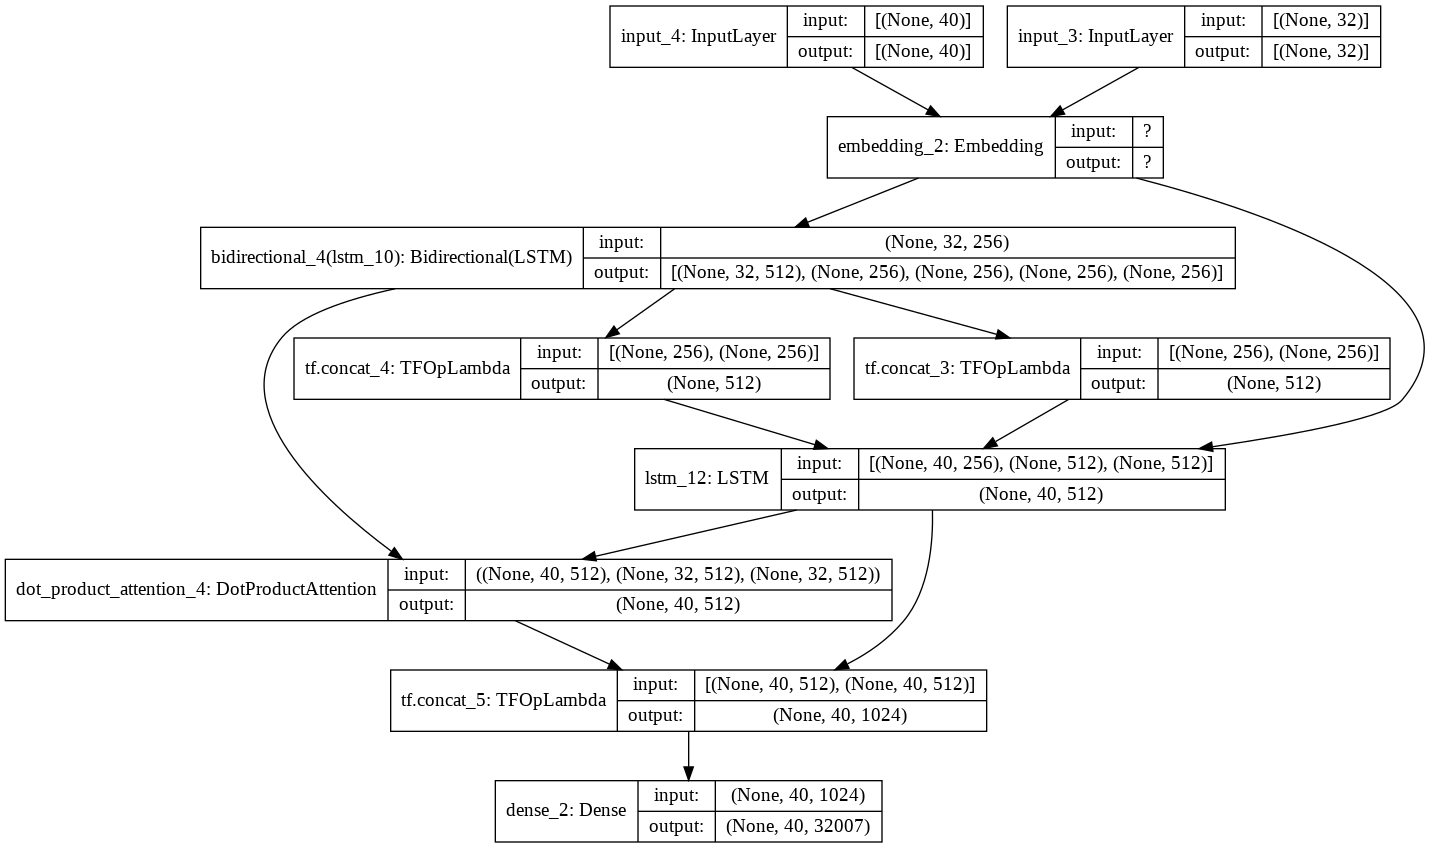

In [63]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [64]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [65]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm_dot.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm_dot.csv'))

In [66]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 42s 818ms/step - loss: 1.8687 - lm_acc: 0.1022

Epoch 00001: lm_acc improved from -inf to 0.11879, saving model to /content/drive/MyDrive/data/songys/lstm_dot.hdf5
Epoch 2/100
47/47 [==============================] - 39s 838ms/step - loss: 1.2798 - lm_acc: 0.1707

Epoch 00002: lm_acc improved from 0.11879 to 0.19812, saving model to /content/drive/MyDrive/data/songys/lstm_dot.hdf5
Epoch 3/100
47/47 [==============================] - 40s 862ms/step - loss: 1.1448 - lm_acc: 0.2697

Epoch 00003: lm_acc improved from 0.19812 to 0.27794, saving model to /content/drive/MyDrive/data/songys/lstm_dot.hdf5
Epoch 4/100
47/47 [==============================] - 40s 861ms/step - loss: 1.0770 - lm_acc: 0.3013

Epoch 00004: lm_acc improved from 0.27794 to 0.31255, saving model to /content/drive/MyDrive/data/songys/lstm_dot.hdf5
Epoch 5/100
47/47 [==============================] - 40s 859ms/step - loss: 1.0170 - lm_acc: 0.3401

Epoch 00005: lm_acc im

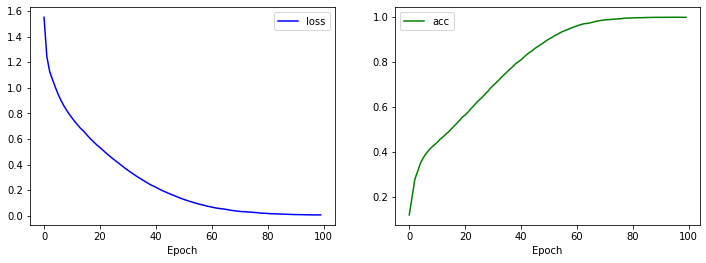

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [68]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm_dot.hdf5'))

In [69]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [70]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 안녕
답변 > 안녕하세요.
질문 > 너는 누구야
답변 > 자신을 우선순위로 해주세요.
질문 > 너 이름이 뭐야
답변 > 제가 따라가려면 멀었네요.
질문 > 나는 누굴까
답변 > 뭐든 좋겠죠.
질문 > 지금 뭐햐
답변 > 저랑 놀아요.
질문 > 잘 하는게 뭐야
답변 > 잘 찾아보세요.
질문 > 피곤해
답변 > 충전하는 시간 그 자체로 소중합니다.
질문 > 졸려
답변 > 오늘 일찍 주무세요.
질문 > 내일은 주말이야
답변 > 기분나쁘겠어요.
질문 > 나 공부해야 돼
답변 > 같이 살고 싶은 사람이 있나봐요.
질문 > 나가기 싫어
답변 > 혼자도 함께도 잘 지내는 게 좋죠.
질문 > 놀고싶어
답변 > 저도 궁금하네요.
질문 >  나 갈래
답변 > 저는 좋아요.
질문 > 잘 자
답변 > 잘자요.
질문 > 다음에 보자
답변 > 잘가요.
질문 > 
